## Class 7 Agenda:
  * **Decision Trees: Regression Trees**
  * **What happens when a single tree is grown too deep?**
  * **Decision Trees: Classification Trees**
  * **Why Have Ensembles?**
  * **Ensembles make excellent machine learning models**
  * **Ensembles of Decision Trees: Random Forests**

In order to use several state-of-the-art machine learning methods, we need to be able to understand their core component: decision trees.

Decision trees, like logistic and linear regression in lesson 5, have been used commonly for machine learning tasks for several decades. These models are fairly easy to understand and and are the basis of the state-of-the-art model that we will build up to today (Random Forests).

Decision trees are especially interesting because they approach the machine learning problem in a way that is quite different from the linear methods we've used so far.

### Regression trees

We are going to motivate this exploration of individual decision trees by looking at another dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test).

This dataset is a collection of measurements of compositional properties of concrete and their effect on the concrete's durability.

The dataset is composed of 7 input measurement features (kilograms per meter cubed of concrete):
  * Cement
  * Slag	
  * Fly ash	
  * Water	
  * SP	
  * Coarse Aggr.	
  * Fine Aggr.
  
And 3 output measurements:
  * SLUMP (cm)	
  * FLOW (cm)	
  * 28-day Compressive Strength (Mpa)

Lets get all of the imports out of the way for the packages we will be working with today:

In [ ]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
import subprocess

In [ ]:
#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

Lets get the data directly off the web this time:

In [ ]:
cement_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data",index_col=0)
#replace spaces and periods in column names with underscores
cement_data.columns = cement_data.columns.str.lower().str.replace(" ","_").str.replace(".","")

We are going to construct a model that predicts the last column (`compressive_strength`) using the 7 input columns.

We are also going to remap the `compressive_strength` column to a few bins so that we can map ranges of output values to colors:

In [ ]:
X,y = cement_data.iloc[:,:7],cement_data.iloc[:,-1]
feature_names_cem = X.columns.tolist()
target_name = cement_data.columns.tolist()[-1]
cement_data["compressive_strength_bins"] = pd.cut(cement_data[target_name],5) #create 5 equally-sized bins

Let's visualize our inputs and outputs in a scatter matrix to get a feel for the data:

In [ ]:
sns.pairplot(cement_data[feature_names_cem+['compressive_strength_bins']],hue="compressive_strength_bins", palette='coolwarm')

Now let's investigate one specific pair of columns that look like they are separable in terms of those bins, `cement`, and `fly_ash`:

In [ ]:
sns.pairplot(cement_data,
             x_vars=['cement'],
             y_vars=["fly_ash"],
             hue='compressive_strength_bins',
             height=6,
             palette="coolwarm")

Lets build a model using just these two features that can give reasonable predictions on `compressive_strength`. We will build it as follows: 
  * Segment the whole space of `cement`/`fly_ash` possibilities into distinct regions
  * Use the **mean compressive_strength in each region** as the predicted `compressive_strength` for that combination of `cement` to `fly_ash` for future concrete samples.
  * Intuitively, we want to **maximize** the similarity (or "homogeneity") of `compressive_strength` within a given region, and **minimize** the similarity of `compressive_strength` between regions. So, more similar colors within a region, distinct colors across regions.

We will follow some strict rules for segmenting the whole space:
  * You can only use **straight lines**
  * Your lines must either be **vertical or horizontal**.
  * Every line **stops** when it hits an existing line.

Before we build our model, lets generate train/test splits of our data:

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=20)

Now lets build our model and check its test error (using **RMSE**):

In [ ]:
decision_tree = DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_train,y_train)
y_prediction = decision_tree.predict(X_test)
print("Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test, y_prediction)))

Lets visualize our decision tree:

In [ ]:
import subprocess

In [ ]:
#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Above is the decision tree created by sklearn and here is how you would read it:

- $R_1$: concrete with **less than or equal to 160.1 $kg/m^3$ of cement and fly ash less than or equal to 136.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **21.24**
- $R_2$: concrete with **less than or equal to 160.1 $kg/m^3$ of cement and fly ash more than 136.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **32.37**
- $R_3$: concrete with **more than 160.1 $kg/m^3$ of cement and fly ash less than or equal to 115.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **31.91**
- $R_4$: concrete with **more than 160.1 $kg/m^3$ of cement and fly ash more than 115.5 $kg/m^3$**, is predicted to have a mean compressive_strength of **43.63**

These regions are used to make predictions on **out-of-sample data**. Thus, there are only 4 possible predictions! (Is this different from how **linear regression** makes predictions?):

In [ ]:
np.unique(decision_tree.predict(X_test))

#### Exercise Time!!!
  * Build a decision tree model to predict slump given the input features.
  * What is the test set RMSE?

In [ ]:
pass

Lets look at the tree again:

In [ ]:
Image(graph.create_png())

The first split is **cement <= 160.1**, thus that split goes at the top of the tree. When a splitting rule is **True**, you follow the left branch. When a splitting rule is **False**, you follow the right branch.

For concrete samples in the **left branch**, there is a further split on **fly_ash <= 136.5**, dividing the samples into 2 compressive_strength regions: 21.24 and 32.37.

For concrete samples in the **right branch**, there is a further split on **fly_ash <= 115.5**, dividing the samples into 2 more compressive_strength regions: 31.91 and 43.63.

**What does this tree tell you about the cement data?**
  * Cement is the most important factor determining compressive_strength, with lower cement concentration generally leading to lower compressive strength.
  * However, fly_ash is an important secondary characteristic, again showing that lower fly_ash concentration leads to lower compressive_strength.

### How does a computer build a regression tree?

**Ideal approach:** Consider every possible partition of the feature space (computationally infeasible)

**"Good enough" approach:** recursive binary splitting:
  * Begin at the top of the tree.
  * For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
  * Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE.
  * Keep repeating the previous step until a **stopping criterion** is met:
    - maximum tree depth is reached (maximum number of splits required to arrive at a leaf, in our case it was 2)
    - minimum number of observations in a leaf (default is 2)

### What happens when we grow a tree too deep?

Lets measure testing error as we add depth to our tree:

In [ ]:
depths = range(1,11)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **test error** occurs for a tree of depth 3.

#### Exercise Time!!!
  * Generate a train/test graph like the one above for the slump model you built earlier. Do the curves look similar to those we just generated above?

In [ ]:
pass

In [ ]:
# max_depth=3 was best, so fit a tree using that parameter
best_single_tree = DecisionTreeRegressor(max_depth=3, random_state=1)
best_single_tree.fit(X_train, y_train)

### Evaluating Feature Importance

The way that we measure the importance of a given feature for a Regression Tree is by computing what is called the [gini importance/coefficient]() of each feature. This measures the normalized total reduction of error when including the given feature.

We can extract the feature importances of any trained tree by extracting its `feature_importances_` property:

In [ ]:
pd.DataFrame({'feature':feature_names_cem, 'importance':best_single_tree.feature_importances_})

#### Exercise Time !!!
  * Examine the feature importances of your slump model. Are they the same as those above? Is the order of the features in terms of their importances the same?

In [ ]:
pass

### Understanding a tree diagram

Lets take a look at our best decision tree:

In [ ]:
dot_data2 = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data2,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph_best = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph_best.create_png())  

How to interpret the internal nodes:

- **samples:** number of observations in that node before splitting
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node
- **rule:** rule used to split that node (go left if true, go right if false)

Reading the leaves (bottom parts of the tree):

- **samples:** number of observations in that node
- **value:** mean response value in that node
- **mse:** MSE calculated by comparing the actual response values in that node against "value"

### Making predictions for the testing data

**Question:** Using the tree diagram above, what predictions will the model make for each test sample observation?

In [ ]:
# use fitted model to make predictions on testing data
y_pred = best_single_tree.predict(X_test)
y_pred

In [ ]:
# calculate test set RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

### Classification trees

**Famous Example:** Decision Tree Model to Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008:

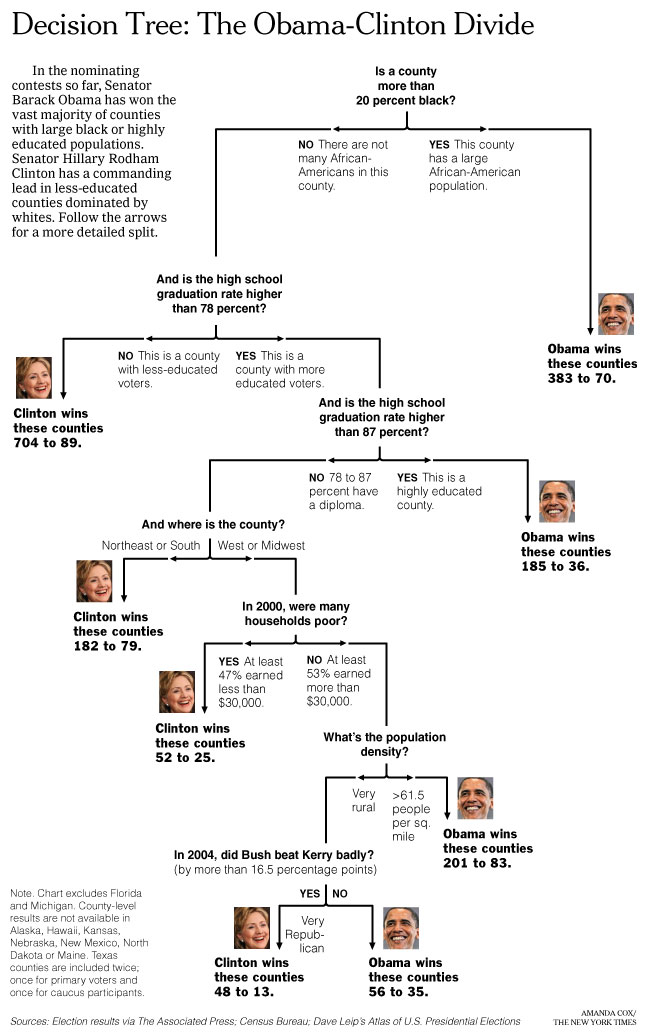

#### Exercise Time!!!

Please answer the following questions about the Obama diagram:
  * What are the observations? How many observations are there?
  - What is the response variable?
  - What are the features?
  - What is the most predictive feature?
  - Why does the tree split on high school graduation rate twice?
  - What is the class prediction for the following counties:
    * 10% African-American, 50% high school graduation rate, located in the South, high poverty, high population density?
    * 18% African-American, 95% high school graduation rate, located in the South, high poverty, high population density?
  - What are the predicted probabilities for both of those counties?

### Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

### Splitting criteria for classification trees

Common options for the splitting criteria when generating classification trees:
  * **classification error rate:** fraction of training observations in a region that don't belong to the most common class
  - **Gini impurity:** measure of how often a randomly chosen element from the set would be incorrectly labeled if it were  randomly labeled according to the distribution of labels in the subset

### Example of classification error rate

Pretend we are predicting whether someone buys an free-standing house or a condo:
  - At a particular node, there are **30 observations** (home buyers), of whom **10 bought free-standing homes and 20 bought condos**.
  - Since the majority class is **condos**, that's our prediction for all 25 observations, and thus the classification error rate is **10/30 = 33%**.

Our goal in making splits is to **reduce the classification error rate**.

Let's try splitting on income:
  - **Greater than 100k/year:** 8 free-standing and 3 condos, thus the predicted class is free-standing
  - **Less than 100k/year:** 2 free-standing and 17 condos, thus the predicted class is condo
  - Classification error rate after this split would be **5/30 = ~17%**
  
Compare that with a split on purchaser-type:
  - **married:** 4 free-standing and 6 condos, thus the predicted class is condo
  - **unmarried:** 6 free-standing and 14 condos, thus the predicted class is condo
  - Classification error rate after this split would be **10/30 = ~33%** (it didnt change!)

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini impurity

Calculate Gini impurity before making a split:

$$1 - \left(\frac {freestanding} {Total}\right)^2 - \left(\frac {condo} {Total}\right)^2 = 1 - \left(\frac {10} {30}\right)^2 - \left(\frac {20} {30}\right)^2 = 0.44$$

- The **maximum value** of Gini impurity is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of Gini impurity is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini impurity score is said to be more "pure".

Let's evaluate the split on **income** using Gini index:
$$\text{more than 100k: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{less than 100k: } 1 - \left(\frac {2} {19}\right)^2 - \left(\frac {17} {19}\right)^2 = 0.19$$
$$\text{Weighted Average: }  0.40 \left(\frac {11} {30}\right) + 0.19 \left(\frac {19} {30}\right) = 0.27$$

Evaluating the split on **purchaser-type** using Gini impurity:
$$\text{married: } 1 - \left(\frac {4} {10}\right)^2 - \left(\frac {6} {10}\right)^2 = 0.48$$
$$\text{unmarried: } 1 - \left(\frac {6} {20}\right)^2 - \left(\frac {14} {20}\right)^2 = 0.42$$
$$\text{Weighted Average: } 0.48 \left(\frac {10} {30}\right) + 0.42 \left(\frac {20} {30}\right) = 0.44$$

The decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini impurity (and thus increases the "node purity") the most.**

### Comparing classification error rate and Gini impurity
  - Gini impurity is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
  - Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
  - scikit-learn's default splitting criteria for classification trees is Gini impurity.
  
There is another common splitting criteria called **cross-entropy**. It's numerically very similar to Gini impurity, but significantly slower to compute.

### Building a classification tree in scikit-learn
We'll build a classification tree using some room-occupancy data recently published at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+).

The dataset is a collection of sensor readings within a given room and manually-validated occupancy checks taken from a camera at 1-minute intervals. If the room was occupied, occupancy is 1, otherwise it is 0.

In [ ]:
# read in the training data
occupancy_data_train = pd.read_csv("data/occupancy_data/datatraining.txt",index_col=0)
occupancy_data_train.date = pd.to_datetime(occupancy_data_train.date) # convert the date column to an actual pandas datetime object
occupancy_data_train.columns = occupancy_data_train.columns.str.lower() #clean up column names by lowercasing them
print(occupancy_data_train.head())

In [ ]:
# read in the testing data
occupancy_data_test = pd.read_csv("data/occupancy_data/datatest.txt",index_col=0)
occupancy_data_test.date = pd.to_datetime(occupancy_data_test.date) # convert the date column to an actual pandas datetime object
occupancy_data_test.columns = occupancy_data_test.columns.str.lower() #clean up column names by lowercasing them
print(occupancy_data_test.head())

In [ ]:
# define X and y - dont use date column as a feature
feature_cols_occ = ["temperature","humidity","light","co2","humidityratio"]
X_occ_train = occupancy_data_train[feature_cols_occ]
y_occ_train = occupancy_data_train.occupancy
X_occ_test = occupancy_data_test[feature_cols_occ]
y_occ_test = occupancy_data_test.occupancy

In [ ]:
# fit a classification tree with max_depth=3 on all of the training data
from sklearn.tree import DecisionTreeClassifier
occupancy_tree = DecisionTreeClassifier(max_depth=3, random_state=1)
occupancy_tree.fit(X_occ_train, y_occ_train)

In [ ]:
#This allows us to make a decision tree real fast directly in the notebook!
dot_data_occ = StringIO()  
export_graphviz(occupancy_tree, out_file=dot_data_occ,  
                    feature_names=X_occ_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
occ_graph = pydotplus.graph_from_dot_data(dot_data_occ.getvalue())  
Image(occ_graph.create_png())

#### Exercise Time!!!
  * Evaluate the model using `accuracy_score` on the testing data.
  * Is the accuracy score above chance? What is chance accuracy here?

In [ ]:
pass

Now let's generate our feature importances:

In [ ]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols_occ, 'importance':occupancy_tree.feature_importances_})

## Comparing decision trees with other models
**Advantages of decision trees:**
  * Can be used for regression or classification
  - Can be displayed graphically
  - Highly interpretable
  - Can be specified as a series of rules, and more closely approximate human decision-making than other models
  - Prediction is fast
  - Features don't need scaling
  - Automatically learns feature interactions (they are non-linear models)
  - Tend to ignore irrelevant features (especially when there are lots of features)
  - Because decision trees are non-linear models they will outperform linear models if the relationship between features and response is highly non-linear
**Disadvantages of decision trees:**
  - Performance is (generally) not competitive with the best supervised learning methods
  - Can easily overfit the training data (tuning is required)
  - Small variations in the data can result in a completely different tree (they are high variance models)
  - Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
  - Don't tend to work well if the classes are highly unbalanced
  - Don't tend to work well with very small datasets

### Ensembles

Consider:
* instead of building a single model to solve a classification problem, 
* you created **five independent models**, 
* If you combined these models into an "ensemble" and used their **majority vote** as a prediction, 
* and each model was **correct about 70% of the time**. 
* *how often would the ensemble be correct?*

In [ ]:
# set a seed for reproducibility
np.random.seed(1234)

# generate 5000 random numbers (between 0 and 1) for each model, representing 5000 observations
mod1 = np.random.rand(5000)
mod2 = np.random.rand(5000)
mod3 = np.random.rand(5000)
mod4 = np.random.rand(5000)
mod5 = np.random.rand(5000)

In [ ]:
# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

In [ ]:
# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

In [ ]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print(ensemble_preds[:20])

In [ ]:
# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

In [ ]:
# how accurate was the ensemble?
print(ensemble_preds.mean())

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform random guessing
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## Ensembling methods

There are two basic methods for ensembling:
- Use a model that ensembles for you (What we will do when we use Random Forests)
- Manually ensemble your individual models

What makes a good "manual ensemble"?
- Different types of models
- Different combinations of features
- Different tuning parameters

Here's an example pipeline that uses ensembling (this is an extreme example):

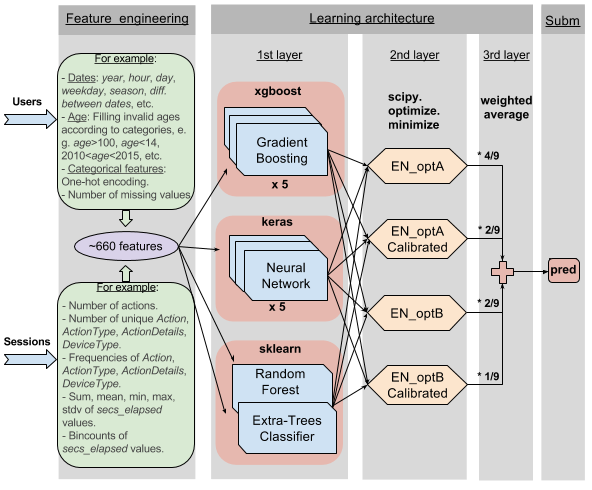

### Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement. Here's an example:

In [ ]:
# set a seed for reproducibility
np.random.seed(20)

# create an array of 1 through 30
nums = np.arange(1, 30)
print("The original array:",nums)

# sample that array 15 times with replacement
print("The 15 samples:",np.random.choice(a=nums, size=15, replace=True))

**Here's how bagging works for decision trees:**
  1. Grow *b* trees using *b* bootstrap samples from the training data.
  2. Train each tree on its bootstrap sample and make predictions.
  3. Combine the predictions:
    * Average the predictions for **regression trees**
    - Take a majority vote for **classification trees**
    
Keep in mind:
  - **Each bootstrap sample** should be the same size as the original training set.
  - **_b_** should be a large enough value that the error seems to have "stabilized".
  - The trees are **grown deep** so that they have low bias/high variance.
  
Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times and averaging the results.

### Manually implementing bagged regression trees (with *b*=10)

We are going to implement bagging using our original concrete slump test dataset.

Let's generate our training and testing data, perform bagging on the training data, and compare the resulting RMSE on the test set to our original RMSE:

In [ ]:
# set a seed for reproducibility
np.random.seed(1234)

# create ten bootstrap samples (will be used to select rows from the DataFrame)

samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
samples

In [ ]:
X_train.iloc[samples[0], :]

In [ ]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted compressive strength from each tree
predictions = []

# define testing data
X_test_boot = X_test
y_test_boot = y_test

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train_boot = X_train.iloc[sample, :]
    y_train_boot = y_train.iloc[sample]
    treereg.fit(X_train_boot, y_train_boot)
    y_pred_boot = treereg.predict(X_test_boot)
    predictions.append(y_pred_boot)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

In [ ]:
# average the predictions
np.mean(predictions, axis=0)

In [ ]:
# calculate RMSE for bagged regression trees
y_pred_boot = np.mean(predictions, axis=0)
print("Bagged RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_boot)))

#calculate RMSE for single decision tree with same exact parameters as each tree in the bag
single_tree = DecisionTreeRegressor(max_depth=None, random_state=123)
single_tree.fit(X_train,y_train)
y_pred_single = single_tree.predict(X_test)
print("Single Tree RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_single)))

Pretty cool, huh?

Now let's implement this with much less code using scikit-learn (and lets make 500 trees, instead of 10):

In [ ]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1234)
# fit and predict
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)
y_pred_bag

In [ ]:
# calculate RMSE
print("Bagged RMSE with 500 trees:",np.sqrt(mean_squared_error(y_test, y_pred_bag)))

### Estimating out-of-sample error (no cross-validation needed!)

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [ ]:
# show the first bootstrap sample
samples[0]

In [ ]:
# show the "in-bag" observations for each sample
for sample in samples:
    print(set(sample))

In [ ]:
# show the "out-of-bag" observations for each sample
all_samples = range(61) #the the sampled data was simply the 61 rows of the training dataset 
for sample in samples:
    sample_difference = set(all_samples) - set(sample) #need to cast both samples into a set, take their set difference
    print("Samples not in bootstrapped set:",sorted(sample_difference))

Here's how to calculate **"out-of-bag error":**
  1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a majority vote (for classification).
  2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When *b* is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [ ]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for b=500
bagreg.oob_score_

### Estimating feature importance across many trees

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:
  * **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, average over all trees
  - **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, average over all trees

### Random Forests are even better than Bagged Trees

Random Forests are a **slight variation of bagged trees** that have even better performance:
  - Just like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
  - However, when building each tree, each time a split is considered, a **random sample of _m_ features** is chosen as split candidates from the **full set of _p_ features**. The split is only allowed to use **one of those _m_ features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, *m* is typically chosen to be the square root of *p* (the total number of features).
    - For **regression**, *m* is typically chosen to be somewhere between *p*/3 and *p*.
    
Why do all of this fancy stuff?
  - Lets suppose there is **one very predictive feature** in the data set. When using bagged trees, most of the trees will use that feature at the top split, resulting in an ensemble of trees that are **highly correlated**.
  - Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
  - By randomly leaving out candidate features from each split, **Random Forests "decorrelate" the trees**, such that the averaging process reduces the variance of the resulting model.

### Random Forests vs. Bagged Trees vs. Single Tree

Let's look back at the cement slump test data and compare the test data performance across the 3 methods we've talked about so far:

In [ ]:
#Our data
X_cem = cement_data[feature_names_cem]
y_cem = cement_data[target_name]
X_train,X_test,y_train,y_test = train_test_split(X_cem,y_cem,test_size=0.4)

In [ ]:
#Single Tree
best_single_tree = DecisionTreeRegressor(max_depth=3, random_state=123)
best_single_tree.fit(X_train, y_train)
y_pred_single = best_single_tree.predict(X_test)

In [ ]:
#Bag of 500 trees
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)

In [ ]:
#Random forest of 500 trees
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
print("Single Tree RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_single)))
print("Bag RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_bag)))
print("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

### Tuning Random Forests: # of trees and maximum features used

2 important parameters that should be tuned when creating a random forest model are:
  * The number of trees to grow (called **n_estimators** in scikit-learn)
  * The number of features that should be considered at each split (called **max_features** in scikit-learn)

Lets tune each feature separately below, starting with **n_estimators**:

In [ ]:
# list of values to try for n_estimators
estimator_range = range(20, 500, 20)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
sns.mpl.pyplot.plot(estimator_range, RMSE_scores)
sns.mpl.pyplot.xlabel('n_estimators')
sns.mpl.pyplot.ylabel('RMSE (lower is better)')

**n_estimators** should be a large enough value such that the error seems to be stable.

Now lets do the same thing with **max_features**:

In [ ]:
# list of values to try for max_features
feature_range = range(1, len(feature_names_cem)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=220, bootstrap=True, 
                                  oob_score=True, max_features=feature, random_state=1234)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
sns.mpl.pyplot.plot(feature_range, RMSE_scores)
sns.mpl.pyplot.xlabel('max_features')
sns.mpl.pyplot.ylabel('RMSE (lower is better)')

So it looks like using all of the features is best. Let's build the optimal classifier we can given what we know and see the overall performance on the test set:

In [ ]:
rfreg_best = RandomForestRegressor(n_estimators=500, max_features=7, bootstrap=True, oob_score=True, random_state=123)
rfreg_best.fit(X_train,y_train)
preds = rfreg_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("Best RMSE:",rmse)

And lets take a look at the feature importances:

In [ ]:
# compute feature importances
pd.DataFrame({'feature':feature_names_cem, 'importance':rfreg_best.feature_importances_}).sort_values(by='importance',ascending=False)

#### Exercise Time
  * Build a Random Forest Regression Model to predict Flow using the concrete slump test dataset.
    * What is the test-set RMSE?
    * What are the feature importances? Are they in a different ranked order than those for the compressive_strength model?
  * Build a Random Forest Classification Model on the occupancy data, using the `datatraining.txt` data
    * What is the test-set Accuracy when testing on `datatest.txt`? When testing on `datatest2.txt`?
    * What are the feature importances?

In [ ]:
pass

### Comparing Random Forests with Single Decision Trees

**Advantages of Random Forests:**
  * Performance is competitive with the best supervised learning methods
  - Provides a more reliable estimate of feature importance
  - Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**
  - Less interpretable
  - Slower to train
  - Slower to predict

### Comparing Ensembles to Individual Models
**Advantages of ensembling:**
  - Increases predictive accuracy
  - Easy to get started (especially with Random Forests)

**Disadvantages of ensembling:**
  - Decreases interpretability
  - Takes longer to train/predict
  - More complex to automate and maintain
  - Sometimes marginal gains in accuracy may not be worth the added complexity